In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


## DataGenerator

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/ankitesg/data/CESM2_f19_v13_updated_NN_pelayout01_ens_07.cam.h1.2003-01-22-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
DATA_DIR = '/DFS-L/DATA/pritchard/ankitesg/datav3/'
hyam = coor.hyam
hybm = coor.hybm
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']

In [3]:
class DataGeneratorClimInvRealGeo(DataGenerator):

    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train', exp=None):
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.exp = exp
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div


    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        return X_norm, Y

In [4]:
in_vars = ['QBP','TBP','CLDLIQBP','CLDICEBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND', 'CLDICEBCTEND', 'NN2L_FLWDS', 'NN2L_PRECC', 
            'NN2L_PRECSC', 'NN2L_SOLL', 'NN2L_SOLLD', 'NN2L_SOLS', 'NN2L_SOLSD', 'NN2L_NETSW']

In [5]:
TRAINFILE = 'RG_SP_M4K_train_shuffle.nc'
NORMFILE = 'RG_SP_M4K_NORM_norm.nc'
VALIDFILE = 'RG_SP_M4K_valid.nc'

In [6]:
train_gen_bf = DataGeneratorClimInv(
    data_fn = f'{DATA_DIR}{TRAINFILE}',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f'{DATA_DIR}{NORMFILE}',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


In [7]:
valid_gen_bf = DataGeneratorClimInv(
    data_fn = f'{DATA_DIR}{VALIDFILE}',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f'{DATA_DIR}{NORMFILE}',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


In [8]:
valid_gen_bf[0][1].shape

(1024, 112)

## Brute Force Network

In [9]:
inp = Input(shape=(108,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(112, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [10]:
model = Sequential()
model.add(Input(shape=(108,)))
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
for i in range (6):
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.3))
model.add(Dense(112, activation='linear'))

In [28]:
model.compile(optimizer='adam', loss='mse')

In [15]:
# model.compile(tf.keras.optimizers.Adam(), loss="mse")
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'BF_RGV3.h5',save_best_only=True, monitor='val_loss', mode='min')

In [30]:
with tf.device('/gpu:0'):
    Nep = 15
    model.fit_generator(train_gen_bf, epochs=Nep, validation_data=valid_gen_bf,\
                  callbacks=[earlyStopping, mcp_save])

Epoch 1/15
42120/42120 [==============================] - ETA: 0s - batch: 21059.5000 - size: 1024.0000 - loss: 234.2806WARNING:tensorflow:From /export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
42120/42120 [==============================] - 463s 11ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 234.2806 - val_loss: 200.5463
Epoch 2/15
42120/42120 [==============================] - 450s 11ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 191.7961 - val_loss: 186.7473
Epoch 3/15
42120/42120 [==============================] - 455s 11ms/step - batch: 21059.5000 - size: 1024.0000 - loss: 183.7222 - val_loss: 185.9941
Epoch 4/15
42120/42120 [==============================

## Model Diagnostics

In [16]:
config_file = 'CI_RG_M4K_CONFIG.yml' # Configuration file
data_file = ['RG_SP_M4K_valid.nc']  # Validation/test data sets
NNarray = ['BF_RGV3.h5'] # NN to evaluate 
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
NNname = ['BF'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [17]:
# Indices of different variables
PHQ_idx = slice(0,26)
TPHYSTND_idx = slice(26,52)

In [18]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    model = path
    exp=None

    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=None, inp_divRH=None,
                                     inp_subTNS=None,inp_divTNS=None,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/datav3/'+data,
                                              nlat=96,nlon=144,nlev=26)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  BF_RGV3.h5
data name is  RG_SP_M4K_valid.nc
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [19]:
mdx =  md['BF_RGV3.h5'][data_file[0][6:-3]] 
mdx.compute_stats(niter=48)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.



/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:177: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:183: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [55]:
tendencies = out_vars[:4]

In [72]:
mdx.stats['mse'].shape

(96, 144, 112)

**MSE**

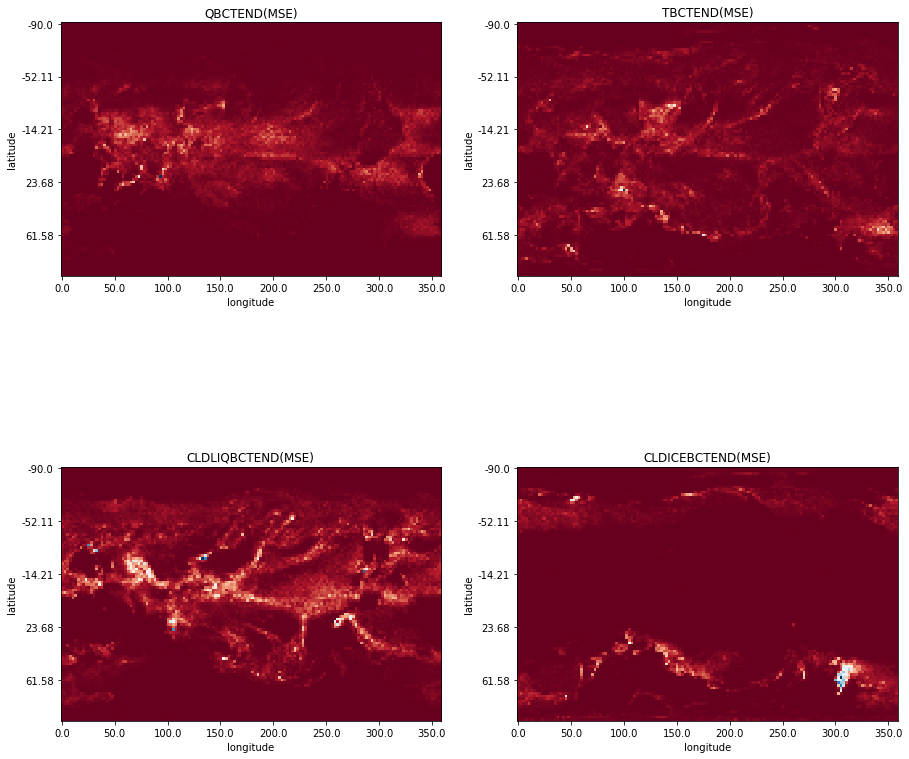

In [69]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
for i,t in enumerate(tendencies):
    axarr[i].imshow(mdx.stats['mse'][:,:,(i+1)*25],cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("longitude")
    axarr[i].set_ylabel("latitude")
    axarr[i].set_title(f"{t}(MSE)")
    axarr[i].set_xticks(np.arange(0,141,20))
    axarr[i].set_xticklabels(x_ticks)
    axarr[i].set_yticks(np.arange(0,81,20))
    axarr[i].set_yticklabels(y_ticks)

**BIAS**

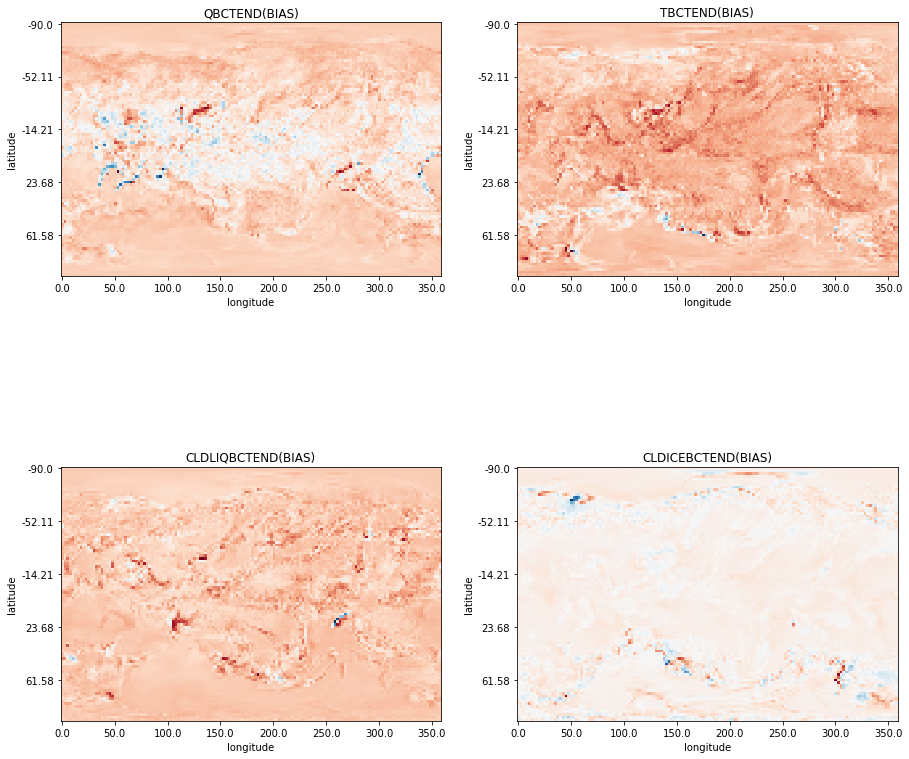

In [68]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
for i,t in enumerate(tendencies):
    axarr[i].imshow(mdx.stats['bias'][:,:,(i+1)*25],cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("longitude")
    axarr[i].set_ylabel("latitude")
    axarr[i].set_title(f"{t}(BIAS)")
    axarr[i].set_xticks(np.arange(0,141,20))
    axarr[i].set_xticklabels(x_ticks)
    axarr[i].set_yticks(np.arange(0,81,20))
    axarr[i].set_yticklabels(y_ticks)

**Mean along longitude**

**MSE**

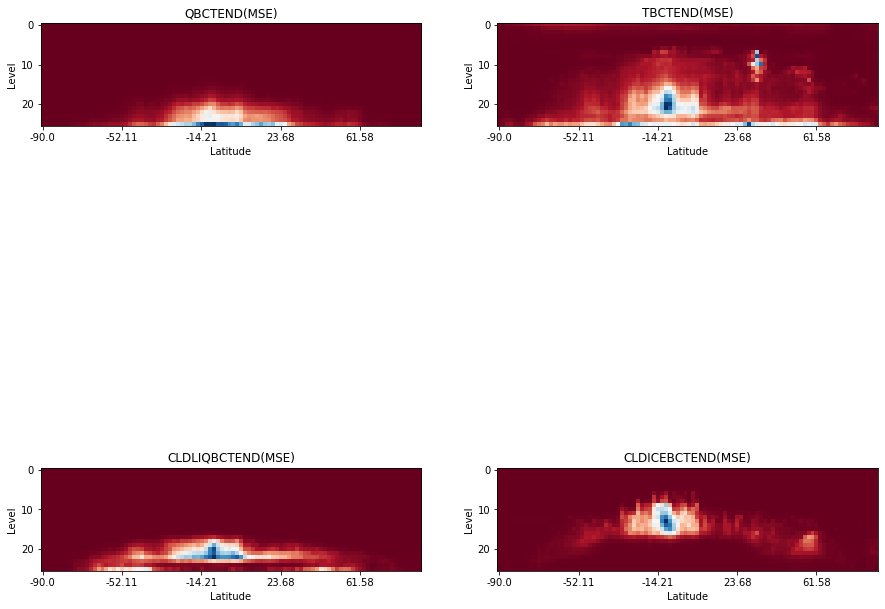

In [73]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
lon_mean = np.mean(mdx.stats['mse'],axis=1)
for i,t in enumerate(tendencies):
    axarr[i].imshow(lon_mean[:,i*26:(i+1)*26].T,cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("Latitude")
    axarr[i].set_ylabel("Level")
    axarr[i].set_title(f"{t}(MSE)")
    axarr[i].set_xticks(np.arange(0,81,20))
    axarr[i].set_xticklabels(y_ticks)

**BIAS**

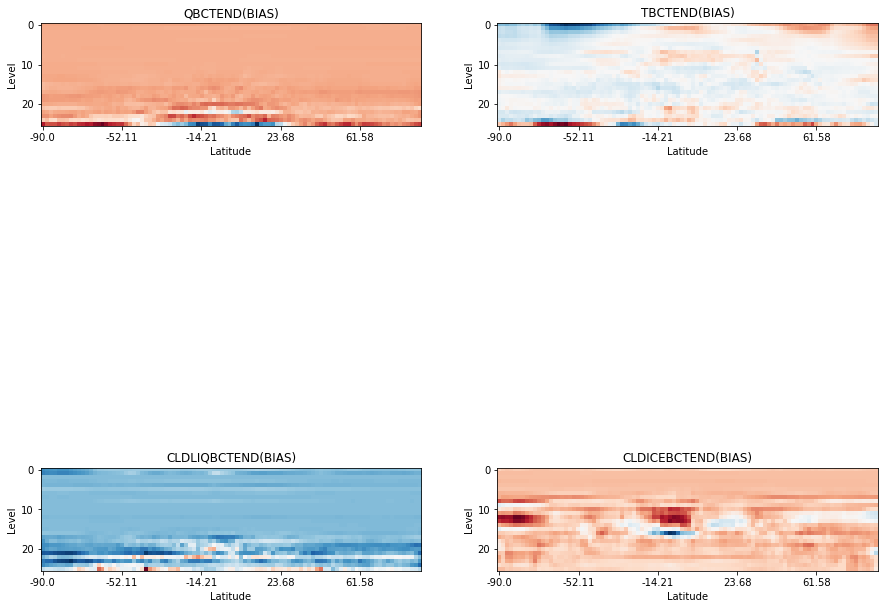

In [74]:
ilev = 25
y_ticks = lat.values[np.arange(0,81,20)]
y_ticks = np.around(y_ticks,decimals=2)
x_ticks = lon.values[np.arange(0,141,20)]
f, axarr = plt.subplots(2,2,figsize=(15, 15))
axarr = axarr.flatten()
lon_mean = np.mean(mdx.stats['bias'],axis=1)
for i,t in enumerate(tendencies):
    axarr[i].imshow(lon_mean[:,i*26:(i+1)*26].T,cmap=plt.cm.RdBu)
    axarr[i].set_xlabel("Latitude")
    axarr[i].set_ylabel("Level")
    axarr[i].set_title(f"{t}(BIAS)")
    axarr[i].set_xticks(np.arange(0,81,20))
    axarr[i].set_xticklabels(y_ticks)